In [1]:
from main import * 

from ultralytics import YOLO


# Image Processing 

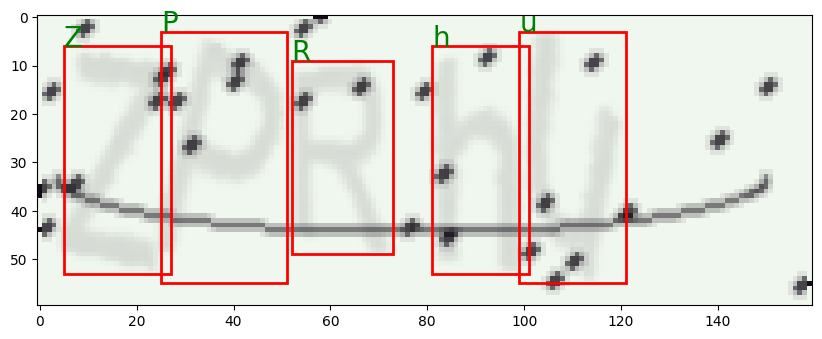

In [2]:
# Load an example image
sample_idx = 0
img_path = os.path.join(IMG_FOLDER, f"{sample_idx}.png")
image_example = load_image(img_path)
ann_path = os.path.join(ANN_FOLDER, f"{sample_idx}.png.json")
ann_example = load_annotation(ann_path)

img = TrainImage(image=image_example, annotations=ann_example)
img.show_with_bounding_boxes()


# Modeling

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from typing import List, Tuple, Optional, Dict

In [13]:
class Conv(nn.Module):
    """
    https://d2l.ai/chapter_convolutional-neural-networks/channels.html
    """
    def __init__(
        self, in_channels, out_channels, 
        kernel_size=1, stride=1, padding=None,
        groups=1, bias=False
    ):
        super().__init__()
        if padding is None:
            min_padding = 1 
            padding = max(min_padding, kernel_size // 2)
        self.conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=bias
        )
        self.bn = nn.BatchNorm2d(out_channel)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DWConv(Conv):
    """
    Depthwise Convolution is a type of convolution where we apply a single 
    convolutional filter for each input channel. 
    In the regular 2D convolution performed over multiple input channels,
    the filter is as deep as the input and lets us freely mix channels 
    to generate each element in the output. In contrast, 
    depthwise convolutions keep each (input) channel separate, 
    i.e., applies one filter per input channel. 
    To summarize the steps, we:
     - Split the input and filter into channels.
     - We convolve each input with the respective filter.
     - We stack the convolved outputs together.
    """ 
    def __init__(
        self, in_channels, out_channels, 
        kernel_size=1, stride=1, padding=None,
        bias=False
    ):
        groups = math.gcd(in_channels, out_channels) 
        super().__init__(
            self, in_channels, out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding,
            groups=groups, bias=bias
        )

        

In [14]:
import logging 

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [15]:
class Bottleneck(nn.Module):
    """
    Also can be seen as a residual + conv layers. 
    """
    def __init__(
        self, in_channels, out_channels, shortcut=True,
        group=1, expansion=0.5
    ):
        hidden_channels = int(out_channels * expansion) 
        self.conv1 = Conv(in_channels, hidden_channels, 1)
        self.conv2 = Conv(hidden_channels, out_channels, 3, groups=groups)
        if in_channels != out_channels:
            logger.warn(
                f"in_channels ({in_channels}) != out_channels {out_channels}",
            )
        self.add = shortcut and in_channels == out_channels 

    def forward(self, x): 
        return x + self.conv2(self.conv1(x)) if self.add else self.conv2(self.conv1(x))                

In [ ]:
class C2F(nn.Module):
    def __init__(
        self, in_channels, out_channels, 
        kernel, n=1, stride=1, shortcut=False, 
        groups=1, expanasion=0.5
    ):
        """
        n = depth
        """
        super().__init__()
        c = int(out_channels * expansion)
        # The one that we will be adding output too
        self.conv_1 = Conv(in_channels, 2 * c, 1)  
        # The one that will handle concatinated output 
        seff.conv_2 = Conv((2+n) * c, out_channels, 1)

        self.m = nn.ModuleList(
            Bottleneck(c, c, shortcut, groups, expansion=1) for _ in range(n)
        )

    def forward(x):
        y = list(self.conv_1(x).chunk(2, 1))
        y.extend(bottleneck(y[-1]) for bottleneck in self.m)
        
        return self.conv_2(torch.cat(y,1))

In [ ]:
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer"""
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        hidden_channels = in_channels // 2
        self.cv1 = Conv(in_channels, hidden_channels, 1)
        self.cv2 = Conv(hidden_channels * 4, out_channels, 1)
        # ToDo: double check if the maxpooling layer has proper dimensions 
        self.m = nn.MaxPool2d(
            kernel_size=kernel_size, 
            stride=1, 
            padding=kernel_size // 2
        )

    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)
        y3 = self.m(y2)
        return self.cv2(torch.cat([x, y1, y2, y3], 1))

In [ ]:
class Detect(nn.Module):
    def __init__(
        self, num_classes, in_channels=(64, 128, 256), strides, 
    ):
        super().__init__()
        self.dfl_channels = 16 
        self.num_classes = num_classes
        sefl.num_outputs = num_classes + 4 # number of outputs per anchor 
        self.num_layers = len(in_channels)
        self.stride = torch.tensor(strides)

        c1 = max(in_channels[0], self.num_classes)
        c2 = max((in_channels[0] // 4, self.ch * 4))

        self.dfl = DFL(self.dfl_channels)
        self.cls = torch.nn.ModuleList(
            torch.nn.Sequential(
                Conv(x, c1, 3),
                Conv(c1, c1, 3),
                torch.nn.Conv2d(c1, self.num_classes, 1)
            ) 
            for x in filters
        )
        self.box = torch.nn.ModuleList(
            torch.nn.Sequential(
                Conv(x, c2, 3),
                Conv(c2, c2, 3),
                torch.nn.Conv2d(c2, 4 * self.dfl_channels, 1)
            ) for x in filters
        )